In [1]:
import torch
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt

from datetime import datetime

import params.learning
from params.learning import LEARNING, NET_PARAMS
from utils import compute_mean_std
from dataset import train_loader, val_loader, test_loader
from model import ResNet18Velocity_Regression_Alt
from train import train
from validate import validate
from test import test
from result import parameters_table, generate_log

from params import PROJECT_PATH

plt.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
    }
)

device = "cuda" if torch.cuda.is_available() else "cpu"

## Prepare data

#### Compute the mean and the standard deviation of the images set

In [2]:
NORMALIZE_PARAMS = params.learning.NORMALIZE_PARAMS

normalize_params_recompute = False

if normalize_params_recompute:
    mean, std = compute_mean_std("images_train", "traversal_costs_train.csv")
    NORMALIZE_PARAMS = {
        "rbg": {"mean": mean[:3], "std": std[:3]},
        "depth": {"mean": mean[3], "std": std[3]},
        "normal": {"mean": mean[4:], "std": std[4:]},
    }

print(NORMALIZE_PARAMS)

{'rbg': {'mean': tensor([0.4710, 0.5030, 0.4580]), 'std': tensor([0.1965, 0.1859, 0.1955])}, 'depth': {'mean': tensor([0.0855]), 'std': tensor([0.0684])}, 'normal': {'mean': tensor([0.4981, 0.5832, 0.8387]), 'std': tensor([0.1720, 0.1991, 0.1468])}}


## Training and validation

In [3]:
model = ResNet18Velocity_Regression_Alt(
    nb_input_channels=NET_PARAMS["nb_input_channels"],
    nb_input_features=NET_PARAMS["nb_input_features"],
    nb_classes=1,
).to(device=device)

#### Visualize the model

In [4]:
# Open TensorBoard
# tensorboard = SummaryWriter()

# Display the architecture in TensorBoard
# images, traversal_costs, traversability_labels, linear_velocities = next(iter(train_loader))
# images = images.to(device)
# linear_velocities = linear_velocities.type(torch.float32).to(device)

# Add a dimension to the linear velocities tensor
# linear_velocities.unsqueeze_(1)

# tensorboard.add_graph(model, (images, linear_velocities))

print(model)
# print(torchsummary.summary(model, (3, 100, 100)))
# print([(name, param.shape) for name, param in model.named_parameters()])
# print(model.fc.state_dict())

ResNet18Velocity_Regression_Alt(
  (resnet18): ResNet(
    (conv1): Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.

In [5]:
criterion_regression = nn.MSELoss()

optimizer = optim.SGD(
    model.parameters(),
    lr=LEARNING["learning_rate"],
    momentum=LEARNING["momentum"],
    weight_decay=LEARNING["weight_decay"],
)

scheduler = optim.lr_scheduler.LinearLR(
    optimizer=optimizer, total_iters=LEARNING["nb_epochs"]
)

# Create tensors to store the loss and accuracy values
regression_loss_values = torch.zeros(2, LEARNING["nb_epochs"])

for epoch in range(LEARNING["nb_epochs"]):
    train_regression_loss = train(
        model,
        device,
        train_loader,
        optimizer,
        scheduler,
        criterion_regression,
        epoch,
    )

    val_regression_loss = validate(
        model, device, val_loader, criterion_regression, epoch
    )

    print("Train regression loss: ", train_regression_loss)
    print("Validation regression loss: ", val_regression_loss)

    regression_loss_values[0, epoch] = train_regression_loss
    regression_loss_values[1, epoch] = val_regression_loss

#     # Add the losses to TensorBoard
#     tensorboard.add_scalar("train_loss", train_loss, epoch)
#     tensorboard.add_scalar("val_loss", val_loss, epoch)
#     # Add the accuracies to TensorBoard
#     tensorboard.add_scalar("train_accuracy", train_accuracy, epoch)
#     tensorboard.add_scalar("val_accuracy", val_accuracy, epoch)
#     # Add the regression losses to TensorBoard
#     tensorboard.add_scalar("train_regression_loss", train_regression_loss, epoch)
#     tensorboard.add_scalar("val_regression_loss", val_regression_loss, epoch)

# # Close TensorBoard
# tensorboard.close()

  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  2.825985347663147
Validation regression loss:  1.5677954139187933


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.7748379059459851
Validation regression loss:  1.494511275490125


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.7023817955151848
Validation regression loss:  1.4685402969519297


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.6213460558134576
Validation regression loss:  1.356682010491689


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.5463701734940212
Validation regression loss:  1.2865538368622462


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.4627704512381898
Validation regression loss:  1.1912639752030372


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.3921959914159083
Validation regression loss:  1.2406063596407573


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.3191863846951637
Validation regression loss:  1.0614784916241964


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.2634902526287064
Validation regression loss:  1.060719719529152


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.2186683215524838
Validation regression loss:  1.031480244298776


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.1725993896092193
Validation regression loss:  1.0926605929931006


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.1569719238989595
Validation regression loss:  0.9331964408357938


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.1373521340066108
Validation regression loss:  0.9579897940158844


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.1173760473080303
Validation regression loss:  0.9564964974919955


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.1055306632449662
Validation regression loss:  0.9705307612816493


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.0666603544268056
Validation regression loss:  0.9227160260081291


  0%|          | 0/276 [00:00<?, ?batch/s]

KeyboardInterrupt: 

## Testing

#### Testing the model

In [ ]:
test_regression_loss, _ = test(
    model, device, test_loader, criterion_regression
)

print("Regression loss: ", test_regression_loss)

Regression loss:  1.03655241082112


#### Generate a log directory

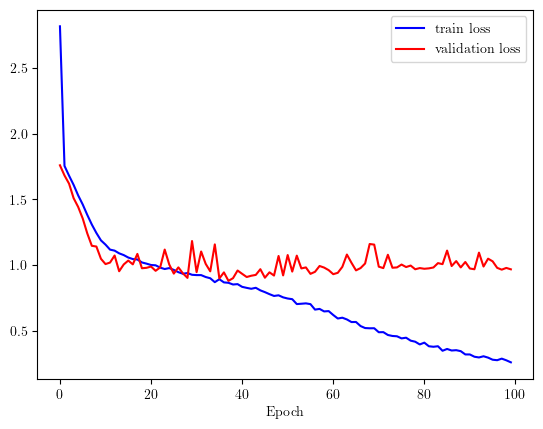

In [ ]:
params_table = parameters_table(
    dataset=params.learning.DATASET, learning_params=LEARNING
)

# Set the path to the results directory
if params.learning.LOG_DIR:
    results_directory = Path("logs/_" + params.learning.LOG_DIR)
else:
    results_directory = Path(
        "logs/_" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    )

generate_log(
    results_directory=results_directory,
    test_regression_loss=test_regression_loss,
    parameters_table=params_table,
    model=model,
    regression_loss_values=regression_loss_values,
)